In [4]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Parity-check matrix, i.e. H_X and H_Z

K = np.array([[1, 0, 1, 0, 1, 0, 1],
              [0, 1, 1, 0, 0, 1, 1],
              [0, 0, 0, 1, 1, 1, 1]])

print(np.array_equal((K@(K.T))%2, np.zeros((3, 3), dtype=int)))

True


In [6]:
# Error recipe, applicable to X and Z checks

columns = [K[:, i] for i in range(K.shape[1])]
print("Error recipe:")
for idx, col in enumerate(columns):
    print(f"X{idx}/Z{idx}: {col} = {col[0]*(2**0)+col[1]*(2**1)+col[2]*(2**2)}, if_test(X or Z symdromes = {col[0]*(2**0)+col[1]*(2**1)+col[2]*(2**2)}), then X{idx}/Z{idx} is wrong and needs fix.")
    

Error recipe:
X0/Z0: [1 0 0] = 1, if_test(X or Z symdromes = 1), then X0/Z0 is wrong and needs fix.
X1/Z1: [0 1 0] = 2, if_test(X or Z symdromes = 2), then X1/Z1 is wrong and needs fix.
X2/Z2: [1 1 0] = 3, if_test(X or Z symdromes = 3), then X2/Z2 is wrong and needs fix.
X3/Z3: [0 0 1] = 4, if_test(X or Z symdromes = 4), then X3/Z3 is wrong and needs fix.
X4/Z4: [1 0 1] = 5, if_test(X or Z symdromes = 5), then X4/Z4 is wrong and needs fix.
X5/Z5: [0 1 1] = 6, if_test(X or Z symdromes = 6), then X5/Z5 is wrong and needs fix.
X6/Z6: [1 1 1] = 7, if_test(X or Z symdromes = 7), then X6/Z6 is wrong and needs fix.


In [7]:
# Logical state preparation
state_vector_0L = np.zeros(128, dtype=complex)

# By the manual procedures in Excel...
state_vector_0L[int('0000000', 2)] = 1
state_vector_0L[int('0111100', 2)] = 1
state_vector_0L[int('1011010', 2)] = 1
state_vector_0L[int('1100110', 2)] = 1
state_vector_0L[int('1101001', 2)] = 1
state_vector_0L[int('1010101', 2)] = 1
state_vector_0L[int('0110011', 2)] = 1
state_vector_0L[int('0001111', 2)] = 1

# Logical state |0>_L
state_vector_0L = state_vector_0L / np.linalg.norm(state_vector_0L)

print(state_vector_0L)

[0.35355339+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.35355339+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.35355339+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.35355339+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.      

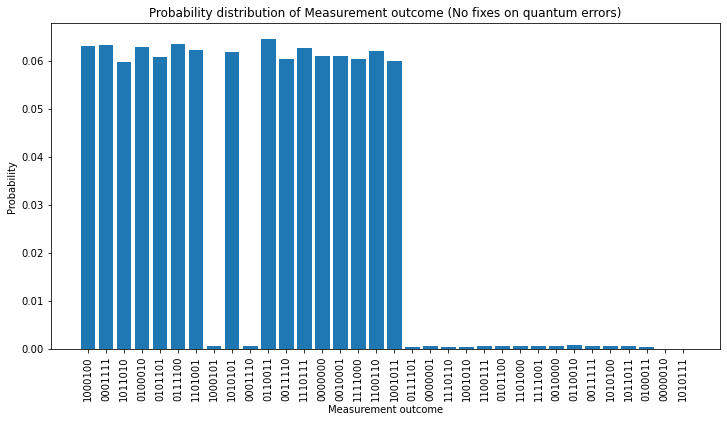

In [11]:
# Quantum error visualization

qubits_for_steanes_code = QuantumRegister(size=7, name="Steane")
qubits_for_X_checks = AncillaRegister(size=3, name="X checks")
qubits_for_Z_checks = AncillaRegister(size=3, name="Z checks")

steane_qc_no_fix = QuantumCircuit(qubits_for_steanes_code, name="Steane's code")

# logical state
steane_qc_no_fix.initialize(state_vector_0L, steane_qc_no_fix.qubits)
steane_qc_no_fix.barrier()

# inject error, 3 small random errors on random qubits, 1 big large fixed error on a fixed qubit
t, p, l = 1e-2 * np.random.rand(3)
loc = np.random.randint(7)
steane_qc_no_fix.u(t, p, l, qubits_for_steanes_code[loc])
t, p, l = 1e-2 * np.random.rand(3)
loc = np.random.randint(7)
steane_qc_no_fix.u(t, p, l, qubits_for_steanes_code[loc])
t, p, l = 1e-2 * np.random.rand(3)
loc = np.random.randint(7)
steane_qc_no_fix.u(t, p, l, qubits_for_steanes_code[loc])
t, p, l = 0.2, 0.3, 0.4
loc = 4
steane_qc_no_fix.u(t, p, l, qubits_for_steanes_code[loc])
steane_qc_no_fix.barrier()

# add ancillas
steane_qc_no_fix.add_register(qubits_for_X_checks)
steane_qc_no_fix.add_register(qubits_for_Z_checks)

# Stabilizer XIXIXIX (row 1 of [7,4,3] Hamming code parity-check matrix)
steane_qc_no_fix.cx(qubits_for_steanes_code[0], qubits_for_X_checks[0])
steane_qc_no_fix.cx(qubits_for_steanes_code[2], qubits_for_X_checks[0])
steane_qc_no_fix.cx(qubits_for_steanes_code[4], qubits_for_X_checks[0])
steane_qc_no_fix.cx(qubits_for_steanes_code[6], qubits_for_X_checks[0])
steane_qc_no_fix.barrier()

# Stabilizer IXXIIXX (row 2 of [7,4,3] Hamming code parity-check matrix)
steane_qc_no_fix.cx(qubits_for_steanes_code[1], qubits_for_X_checks[1])
steane_qc_no_fix.cx(qubits_for_steanes_code[2], qubits_for_X_checks[1])
steane_qc_no_fix.cx(qubits_for_steanes_code[5], qubits_for_X_checks[1])
steane_qc_no_fix.cx(qubits_for_steanes_code[6], qubits_for_X_checks[1])
steane_qc_no_fix.barrier()

# Stabilizer IIIXXXX (row 3 of [7,4,3] Hamming code parity-check matrix)
steane_qc_no_fix.cx(qubits_for_steanes_code[3], qubits_for_X_checks[2])
steane_qc_no_fix.cx(qubits_for_steanes_code[4], qubits_for_X_checks[2])
steane_qc_no_fix.cx(qubits_for_steanes_code[5], qubits_for_X_checks[2])
steane_qc_no_fix.cx(qubits_for_steanes_code[6], qubits_for_X_checks[2])
steane_qc_no_fix.barrier()

# Stabilizer ZIZIZIZ (row 1 of [7,4,3] Hamming code parity-check matrix, but Z version)
# Z = HXH
steane_qc_no_fix.h(qubits_for_Z_checks[0])
steane_qc_no_fix.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[0])
steane_qc_no_fix.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[2])
steane_qc_no_fix.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[4])
steane_qc_no_fix.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[6])
steane_qc_no_fix.h(qubits_for_Z_checks[0])
steane_qc_no_fix.barrier()

# Stabilizer IZZIIZZ (row 2 of [7,4,3] Hamming code parity-check matrix, but Z version)
# Z = HXH
steane_qc_no_fix.h(qubits_for_Z_checks[1])
steane_qc_no_fix.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[1])
steane_qc_no_fix.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[2])
steane_qc_no_fix.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[5])
steane_qc_no_fix.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[6])
steane_qc_no_fix.h(qubits_for_Z_checks[1])
steane_qc_no_fix.barrier()

# Stabilizer IIIZZZZ (row 3 of [7,4,3] Hamming code parity-check matrix, but Z version)
# Z = HXH
steane_qc_no_fix.h(qubits_for_Z_checks[2])
steane_qc_no_fix.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[3])
steane_qc_no_fix.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[4])
steane_qc_no_fix.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[5])
steane_qc_no_fix.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[6])
steane_qc_no_fix.h(qubits_for_Z_checks[2])
steane_qc_no_fix.barrier()

# classic bits to record measurements (syndromes)
X_syndromes = ClassicalRegister(3, name="s_X")
Z_syndromes = ClassicalRegister(3, name="s_Z")
steane_qc_no_fix.add_register(X_syndromes, Z_syndromes)

# If errors are not fixed

# measure
steane_qc_no_fix.measure(qubits_for_X_checks, X_syndromes)
steane_qc_no_fix.measure(qubits_for_Z_checks, Z_syndromes)

# classical bits for corrected data
qubit_measurements = ClassicalRegister(7, name=f"cl")
steane_qc_no_fix.add_register(qubit_measurements)

# measure
steane_qc_no_fix.measure(qubits_for_steanes_code, qubit_measurements)

steane_qc_no_fix.draw('mpl', scale = 0.5, fold = -1)

# Simulator
simulator_no_fix = AerSimulator()

rounds = 50000

# Transpile the circuit for the backend
compiled_circuit_no_fix = transpile(steane_qc_no_fix, simulator_no_fix)

# Run the circuit
job_no_fix = simulator_no_fix.run(compiled_circuit_no_fix, shots=rounds)

# Get the measurement counts
counts_no_fix = job_no_fix.result().get_counts()

distribution = {}

for measurement in counts_no_fix:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts_no_fix[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts_no_fix[measurement] / rounds

bitstrings = list(distribution.keys())
probabilities = list(distribution.values())

plt.figure(figsize=(12, 6))
plt.bar(bitstrings, probabilities)
plt.xlabel('Measurement outcome')
plt.ylabel('Probability')
plt.title('Probability distribution of Measurement outcome (No fixes on quantum errors)')
plt.xticks(rotation=90) 
plt.show()

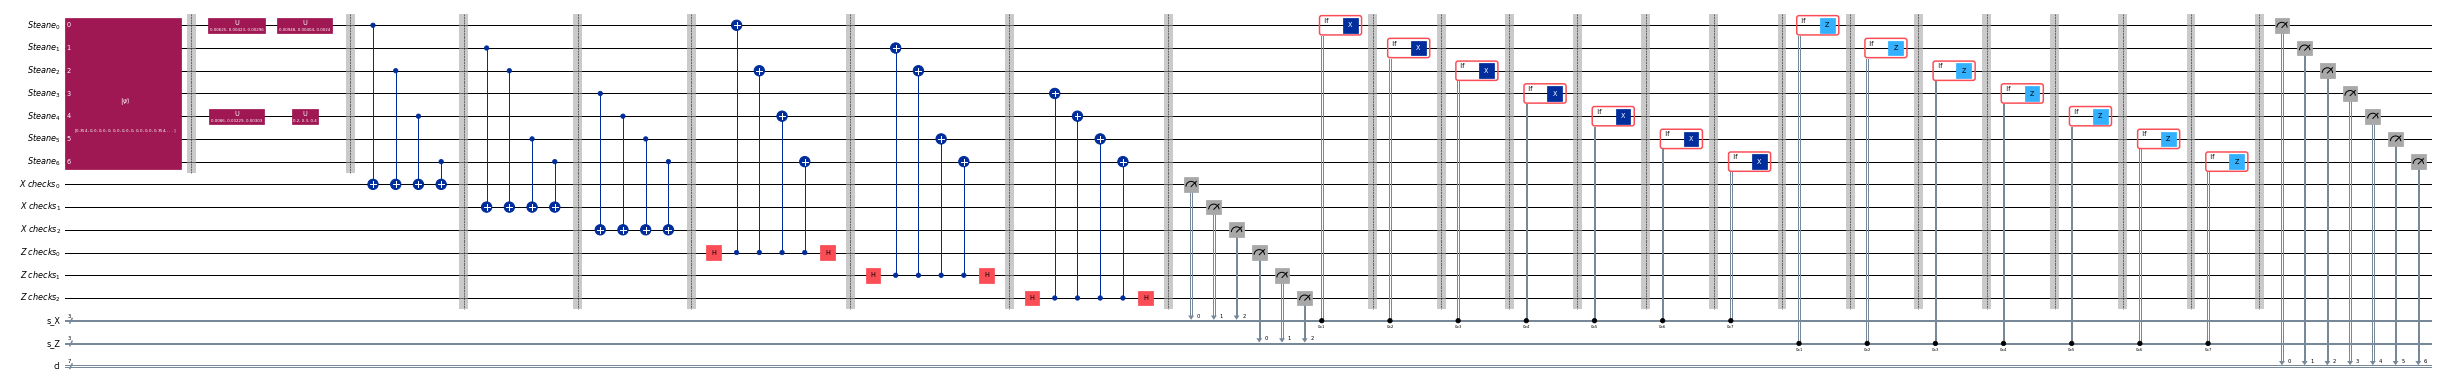

In [12]:
# Quantum error (corrected) visualization

qubits_for_steanes_code = QuantumRegister(size=7, name="Steane")
qubits_for_X_checks = AncillaRegister(size=3, name="X checks")
qubits_for_Z_checks = AncillaRegister(size=3, name="Z checks")

steane_qc = QuantumCircuit(qubits_for_steanes_code, name="Steane's code")

# logical state
steane_qc.initialize(state_vector_0L, steane_qc.qubits)
steane_qc.barrier()

# inject error, 3 small random errors on random qubits, 1 big large fixed error on a fixed qubit
t, p, l = 1e-2 * np.random.rand(3)
loc = np.random.randint(7)
steane_qc.u(t, p, l, qubits_for_steanes_code[loc])
t, p, l = 1e-2 * np.random.rand(3)
loc = np.random.randint(7)
steane_qc.u(t, p, l, qubits_for_steanes_code[loc])
t, p, l = 1e-2 * np.random.rand(3)
loc = np.random.randint(7)
steane_qc.u(t, p, l, qubits_for_steanes_code[loc])
t, p, l = 0.2, 0.3, 0.4
loc = 4
steane_qc.u(t, p, l, qubits_for_steanes_code[loc])
steane_qc.barrier()

# add ancillas
steane_qc.add_register(qubits_for_X_checks)
steane_qc.add_register(qubits_for_Z_checks)

# Stabilizer XIXIXIX (row 1 of [7,4,3] Hamming code parity-check matrix)
steane_qc.cx(qubits_for_steanes_code[0], qubits_for_X_checks[0])
steane_qc.cx(qubits_for_steanes_code[2], qubits_for_X_checks[0])
steane_qc.cx(qubits_for_steanes_code[4], qubits_for_X_checks[0])
steane_qc.cx(qubits_for_steanes_code[6], qubits_for_X_checks[0])
steane_qc.barrier()

# Stabilizer IXXIIXX (row 2 of [7,4,3] Hamming code parity-check matrix)
steane_qc.cx(qubits_for_steanes_code[1], qubits_for_X_checks[1])
steane_qc.cx(qubits_for_steanes_code[2], qubits_for_X_checks[1])
steane_qc.cx(qubits_for_steanes_code[5], qubits_for_X_checks[1])
steane_qc.cx(qubits_for_steanes_code[6], qubits_for_X_checks[1])
steane_qc.barrier()

# Stabilizer IIIXXXX (row 3 of [7,4,3] Hamming code parity-check matrix)
steane_qc.cx(qubits_for_steanes_code[3], qubits_for_X_checks[2])
steane_qc.cx(qubits_for_steanes_code[4], qubits_for_X_checks[2])
steane_qc.cx(qubits_for_steanes_code[5], qubits_for_X_checks[2])
steane_qc.cx(qubits_for_steanes_code[6], qubits_for_X_checks[2])
steane_qc.barrier()

# Stabilizer ZIZIZIZ (row 1 of [7,4,3] Hamming code parity-check matrix, but Z version)
# Z = HXH
steane_qc.h(qubits_for_Z_checks[0])
steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[0])
steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[2])
steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[4])
steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[6])
steane_qc.h(qubits_for_Z_checks[0])
steane_qc.barrier()

# Stabilizer IZZIIZZ (row 2 of [7,4,3] Hamming code parity-check matrix, but Z version)
# Z = HXH
steane_qc.h(qubits_for_Z_checks[1])
steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[1])
steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[2])
steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[5])
steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[6])
steane_qc.h(qubits_for_Z_checks[1])
steane_qc.barrier()

# Stabilizer IIIZZZZ (row 3 of [7,4,3] Hamming code parity-check matrix, but Z version)
# Z = HXH
steane_qc.h(qubits_for_Z_checks[2])
steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[3])
steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[4])
steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[5])
steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[6])
steane_qc.h(qubits_for_Z_checks[2])
steane_qc.barrier()

# classic bits to record measurements (syndromes)
X_syndromes = ClassicalRegister(3, name="s_X")
Z_syndromes = ClassicalRegister(3, name="s_Z")
steane_qc.add_register(X_syndromes, Z_syndromes)

# measure
steane_qc.measure(qubits_for_X_checks, X_syndromes)
steane_qc.measure(qubits_for_Z_checks, Z_syndromes)

# add the X checks, note: if_test() check the syndromes to the equivalent decimals
# e.g. if (X_checks_0, X_checks_1, X_checks_2) = (1, 0, 0) = 1*2^0 + 0*2^1 + 0*2^2 = decimal 1 
# Since 
with steane_qc.if_test((X_syndromes, 1)): 
    steane_qc.x(qubits_for_steanes_code[0])
steane_qc.barrier()    
with steane_qc.if_test((X_syndromes, 2)):
    steane_qc.x(qubits_for_steanes_code[1])
steane_qc.barrier()
with steane_qc.if_test((X_syndromes, 3)):
    steane_qc.x(qubits_for_steanes_code[2])
steane_qc.barrier()
with steane_qc.if_test((X_syndromes, 4)):
    steane_qc.x(qubits_for_steanes_code[3])
steane_qc.barrier()
with steane_qc.if_test((X_syndromes, 5)):
    steane_qc.x(qubits_for_steanes_code[4])
steane_qc.barrier()
with steane_qc.if_test((X_syndromes, 6)):
    steane_qc.x(qubits_for_steanes_code[5])
steane_qc.barrier()
with steane_qc.if_test((X_syndromes, 7)):
    steane_qc.x(qubits_for_steanes_code[6])
steane_qc.barrier()

# add the Z checks
with steane_qc.if_test((Z_syndromes, 1)):
    steane_qc.z(qubits_for_steanes_code[0])
steane_qc.barrier()
with steane_qc.if_test((Z_syndromes, 2)):
    steane_qc.z(qubits_for_steanes_code[1])
steane_qc.barrier()
with steane_qc.if_test((Z_syndromes, 3)):
    steane_qc.z(qubits_for_steanes_code[2])
steane_qc.barrier()
with steane_qc.if_test((Z_syndromes, 4)):
    steane_qc.z(qubits_for_steanes_code[3])
steane_qc.barrier()
with steane_qc.if_test((Z_syndromes, 5)):
    steane_qc.z(qubits_for_steanes_code[4])
steane_qc.barrier()
with steane_qc.if_test((Z_syndromes, 6)):
    steane_qc.z(qubits_for_steanes_code[5])
steane_qc.barrier()
with steane_qc.if_test((Z_syndromes, 7)):
    steane_qc.z(qubits_for_steanes_code[6])
steane_qc.barrier()
    
# classical bits for corrected data
qubit_measurements = ClassicalRegister(7, name=f"cl")
steane_qc.add_register(qubit_measurements)

# measure
steane_qc.measure(qubits_for_steanes_code, qubit_measurements)

steane_qc.draw('mpl', scale = 0.5, fold = -1)

In [13]:
simulator = AerSimulator()

In [14]:
rounds = 50000

# Transpile the circuit for the backend
compiled_circuit = transpile(steane_qc, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=rounds)

# Get the measurement counts
counts = job.result().get_counts()

In [15]:
distribution = {}

for measurement in counts:
    if measurement[:7] in distribution:
        distribution[measurement[:7]] += counts[measurement] / rounds
    else:
        distribution[measurement[:7]] = counts[measurement] / rounds

distribution

{'1100110': 0.0634,
 '0110100': 0.0607,
 '1100001': 0.06372,
 '1001011': 0.06113999999999999,
 '0000111': 0.06369999999999999,
 '1010101': 0.06356,
 '0011001': 0.06076,
 '0110011': 0.063,
 '1111000': 0.06430000000000001,
 '0101010': 0.063,
 '0000000': 0.06432000000000002,
 '0101101': 0.06308,
 '1111111': 0.06128,
 '0011110': 0.061900000000000004,
 '1001100': 0.06014,
 '1010010': 0.062}

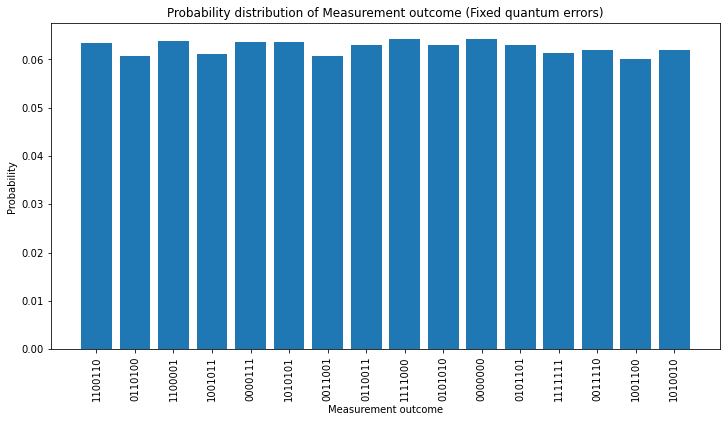

In [16]:
bitstrings = list(distribution.keys())
probabilities = list(distribution.values())

plt.figure(figsize=(12, 6))
plt.bar(bitstrings, probabilities)
plt.xlabel('Measurement outcome')
plt.ylabel('Probability')
plt.title('Probability distribution of Measurement outcome (Fixed quantum errors)')
plt.xticks(rotation=90)
plt.show()

In [40]:
def QEC_success_rate(p):
    
    success_count = 0

    # Quantum error (corrected) visualization

    qubits_for_steanes_code = QuantumRegister(size=7, name="Steane")
    qubits_for_X_checks = AncillaRegister(size=3, name="X checks")
    qubits_for_Z_checks = AncillaRegister(size=3, name="Z checks")

    steane_qc = QuantumCircuit(qubits_for_steanes_code, name="Steane's code")

    # logical state
    steane_qc.initialize(state_vector_0L, steane_qc.qubits)
    steane_qc.barrier()

    # inject error, 3 small random errors on random qubits, 1 big large fixed error on a fixed qubit
    t, p, l = p * np.random.rand(3)
    loc = np.random.randint(7)
    steane_qc.u(t, p, l, qubits_for_steanes_code[loc])
    steane_qc.barrier()

    # add ancillas
    steane_qc.add_register(qubits_for_X_checks)
    steane_qc.add_register(qubits_for_Z_checks)

    # Stabilizer XIXIXIX (row 1 of [7,4,3] Hamming code parity-check matrix)
    steane_qc.cx(qubits_for_steanes_code[0], qubits_for_X_checks[0])
    steane_qc.cx(qubits_for_steanes_code[2], qubits_for_X_checks[0])
    steane_qc.cx(qubits_for_steanes_code[4], qubits_for_X_checks[0])
    steane_qc.cx(qubits_for_steanes_code[6], qubits_for_X_checks[0])
    steane_qc.barrier()

    # Stabilizer IXXIIXX (row 2 of [7,4,3] Hamming code parity-check matrix)
    steane_qc.cx(qubits_for_steanes_code[1], qubits_for_X_checks[1])
    steane_qc.cx(qubits_for_steanes_code[2], qubits_for_X_checks[1])
    steane_qc.cx(qubits_for_steanes_code[5], qubits_for_X_checks[1])
    steane_qc.cx(qubits_for_steanes_code[6], qubits_for_X_checks[1])
    steane_qc.barrier()

    # Stabilizer IIIXXXX (row 3 of [7,4,3] Hamming code parity-check matrix)
    steane_qc.cx(qubits_for_steanes_code[3], qubits_for_X_checks[2])
    steane_qc.cx(qubits_for_steanes_code[4], qubits_for_X_checks[2])
    steane_qc.cx(qubits_for_steanes_code[5], qubits_for_X_checks[2])
    steane_qc.cx(qubits_for_steanes_code[6], qubits_for_X_checks[2])
    steane_qc.barrier()

    # Stabilizer ZIZIZIZ (row 1 of [7,4,3] Hamming code parity-check matrix, but Z version)
    # Z = HXH
    steane_qc.h(qubits_for_Z_checks[0])
    steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[0])
    steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[2])
    steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[4])
    steane_qc.cx(qubits_for_Z_checks[0], qubits_for_steanes_code[6])
    steane_qc.h(qubits_for_Z_checks[0])
    steane_qc.barrier()

    # Stabilizer IZZIIZZ (row 2 of [7,4,3] Hamming code parity-check matrix, but Z version)
    # Z = HXH
    steane_qc.h(qubits_for_Z_checks[1])
    steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[1])
    steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[2])
    steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[5])
    steane_qc.cx(qubits_for_Z_checks[1], qubits_for_steanes_code[6])
    steane_qc.h(qubits_for_Z_checks[1])
    steane_qc.barrier()

    # Stabilizer IIIZZZZ (row 3 of [7,4,3] Hamming code parity-check matrix, but Z version)
    # Z = HXH
    steane_qc.h(qubits_for_Z_checks[2])
    steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[3])
    steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[4])
    steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[5])
    steane_qc.cx(qubits_for_Z_checks[2], qubits_for_steanes_code[6])
    steane_qc.h(qubits_for_Z_checks[2])
    steane_qc.barrier()

    # classic bits to record measurements (syndromes)
    X_syndromes = ClassicalRegister(3, name="s_X")
    Z_syndromes = ClassicalRegister(3, name="s_Z")
    steane_qc.add_register(X_syndromes, Z_syndromes)

    # measure
    steane_qc.measure(qubits_for_X_checks, X_syndromes)
    steane_qc.measure(qubits_for_Z_checks, Z_syndromes)

    # add the X checks, note: if_test() check the syndromes to the equivalent decimals
    # e.g. if (X_checks_0, X_checks_1, X_checks_2) = (1, 0, 0) = 1*2^0 + 0*2^1 + 0*2^2 = decimal 1 
    # Since 
    with steane_qc.if_test((X_syndromes, 1)): 
        steane_qc.x(qubits_for_steanes_code[0])
    steane_qc.barrier()    
    with steane_qc.if_test((X_syndromes, 2)):
        steane_qc.x(qubits_for_steanes_code[1])
    steane_qc.barrier()
    with steane_qc.if_test((X_syndromes, 3)):
        steane_qc.x(qubits_for_steanes_code[2])
    steane_qc.barrier()
    with steane_qc.if_test((X_syndromes, 4)):
        steane_qc.x(qubits_for_steanes_code[3])
    steane_qc.barrier()
    with steane_qc.if_test((X_syndromes, 5)):
        steane_qc.x(qubits_for_steanes_code[4])
    steane_qc.barrier()
    with steane_qc.if_test((X_syndromes, 6)):
        steane_qc.x(qubits_for_steanes_code[5])
    steane_qc.barrier()
    with steane_qc.if_test((X_syndromes, 7)):
        steane_qc.x(qubits_for_steanes_code[6])
    steane_qc.barrier()

    # add the Z checks
    with steane_qc.if_test((Z_syndromes, 1)):
        steane_qc.z(qubits_for_steanes_code[0])
    steane_qc.barrier()
    with steane_qc.if_test((Z_syndromes, 2)):
        steane_qc.z(qubits_for_steanes_code[1])
    steane_qc.barrier()
    with steane_qc.if_test((Z_syndromes, 3)):
        steane_qc.z(qubits_for_steanes_code[2])
    steane_qc.barrier()
    with steane_qc.if_test((Z_syndromes, 4)):
        steane_qc.z(qubits_for_steanes_code[3])
    steane_qc.barrier()
    with steane_qc.if_test((Z_syndromes, 5)):
        steane_qc.z(qubits_for_steanes_code[4])
    steane_qc.barrier()
    with steane_qc.if_test((Z_syndromes, 6)):
        steane_qc.z(qubits_for_steanes_code[5])
    steane_qc.barrier()
    with steane_qc.if_test((Z_syndromes, 7)):
        steane_qc.z(qubits_for_steanes_code[6])
    steane_qc.barrier()

    # classical bits for corrected data
    qubit_measurements = ClassicalRegister(7, name=f"cl")
    steane_qc.add_register(qubit_measurements)

    # measure
    steane_qc.measure(qubits_for_steanes_code, qubit_measurements)

    simulator = AerSimulator()

    rounds = 10000

    # Transpile the circuit for the backend
    compiled_circuit = transpile(steane_qc, simulator)

    # Run the circuit
    job = simulator.run(compiled_circuit, shots=rounds)

    # Get the measurement counts
    counts = job.result().get_counts()

    distribution = {}

    for measurement in counts:
        if measurement[:7] in distribution:
            distribution[measurement[:7]] += counts[measurement]
        else:
            distribution[measurement[:7]] = counts[measurement]
    
    for outcome, count in distribution.items():
        bits = [int(b) for b in outcome[::-1]]
        if bits.count(0) >= 4:
            success_count += count
            
    return(success_count/rounds)

Text(0.5, 1.0, 'Steane Code: Success Rate vs Error Probability')

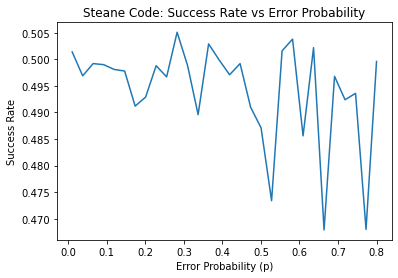

In [41]:
p_values = np.linspace(0.01, 0.80, 30)

success_rate = []

for p in p_values:
    success_rate.append(QEC_success_rate(p))
    
plt.plot(p_values, success_rate)
plt.xlabel("Error Probability (p)")
plt.ylabel("Success Rate")
plt.title("Steane Code: Success Rate vs Error Probability")